# Outliers

Sometimes our data is not nice enough to simply have a `NaN` or zero value to make it easy to tell what we should remove. Sometimes our data has outliers in it. So lets look at some strategies to identifying these points.

Matplotlib is building the font cache; this may take a moment.
(1010,) (1010, 2)


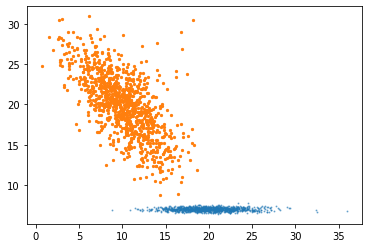

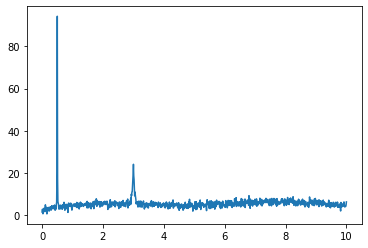

In [1]:
import numpy as np
import matplotlib.pyplot as plt

d1 = np.loadtxt("data\outlier_1d.txt")
d2 = np.loadtxt("data\outlier_2d.txt")
d3 = np.loadtxt("data\outlier_curve.txt")
print(d1.shape, d2.shape)

plt.scatter(d1, np.random.normal(7, 0.2, size=d1.size), s=1, alpha=0.5)
plt.scatter(d2[:, 0], d2[:, 1], s=5)
plt.show();
plt.plot(d3[:, 0], d3[:, 1]);

# Basics

The most basic and most-common way of manually doing outlier pruning on data distributions is to:

1. Model your data as some analytic distribution
2. Find all points below a certain probability
3. Remove them
4. Refit the distributions, and potentially run again from Step 1.

Rejection 5 points
z-score of 3 corresponds to a prob of 0.27%


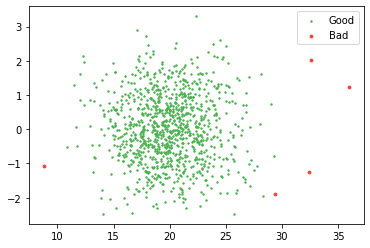

In [3]:
mean, std = np.mean(d1), np.std(d1)
z_score = np.abs((d1 - mean) / std)
threshold = 3
good = z_score < threshold

print(f"Rejection {(~good).sum()} points")
from scipy.stats import norm
print(f"z-score of 3 corresponds to a prob of {100 * 2 * norm.sf(threshold):0.2f}%")
visual_scatter = np.random.normal(size=d1.size)
plt.scatter(d1[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
plt.scatter(d1[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
plt.legend();

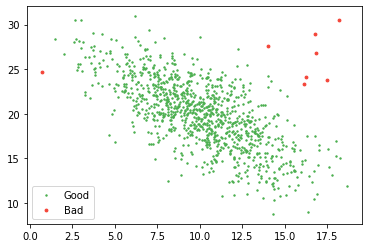

In [4]:
from scipy.stats import multivariate_normal as mn

mean, cov = np.mean(d2, axis=0), np.cov(d2.T)
good = mn(mean, cov).pdf(d2) > 0.01 / 100

plt.scatter(d2[good, 0], d2[good, 1], s=2, label="Good", color="#4CAF50")
plt.scatter(d2[~good, 0], d2[~good, 1], s=8, label="Bad", color="#F44336")
plt.legend();

So, how do we pick what our threshold should be? Visual inspection is actually hard to beat. You can make an argument for relating the number to the number of samples you have or how much of the data you are willing to cut, but be warned that too much rejection is going to eat away at your actual data sample and bias your results.

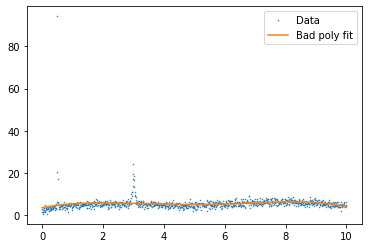

In [5]:
xs, ys = d3.T
p = np.polyfit(xs, ys,deg=5)
ps = np.polyval(p, xs)
plt.plot(xs, ys, ".", label="Data", ms=1)
plt.plot(xs, ps, label="Bad poly fit")
plt.legend();

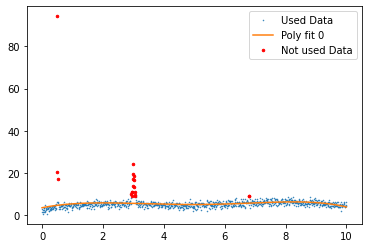

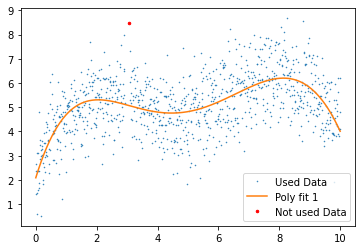

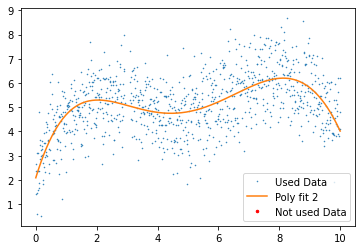

In [6]:
x, y = xs.copy(), ys.copy()
for i in range(5):
    p = np.polyfit(x, y, deg=5)
    ps = np.polyval(p, x)
    good = y - ps < 3  # only remove positive outliers
    
    x_bad, y_bad = x[~good], y[~good]
    x, y = x[good], y[good]
    
    plt.plot(x, y, ".", label="Used Data", ms=1)
    plt.plot(x, np.polyval(p, x), label=f"Poly fit {i}")
    plt.plot(x_bad, y_bad, ".", label="Not used Data", ms=5, c="r")
    plt.legend()
    plt.show()
    
    if (~good).sum() == 0:
        break

# Automating it

Blessed `sklearn` to the rescue. Check out [the main page](https://scikit-learn.org/stable/modules/outlier_detection.html) which lists a ton of ways you can do outlier detection. I think LOF (Local Outlier Finder) is great - it uses the distance from one point to its closest twenty neighbours to figure out point density and removes those in low density regions.

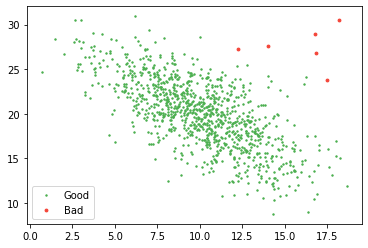

In [8]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.005)
good = lof.fit_predict(d2) == 1
plt.scatter(d2[good, 0], d2[good, 1], s=2, label="Good", color="#4CAF50")
plt.scatter(d2[~good, 0], d2[~good, 1], s=8, label="Bad", color="#F44336")
plt.legend();